# Image Recognition Covid Detection - Multi Classification[1][2]


## Prepare in Google Colab

In [1]:
!pip install jcopdl
!pip install gdown

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=3dce098b9924d714b6f03fd10db7624dfca777d165b4dfddc4668c0927b8181d
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [2]:
!gdown https://drive.google.com/uc?id=1PgF_X5jr_Bqv420Ts4Mlyg56VUmzcQMD

Downloading...
From: https://drive.google.com/uc?id=1PgF_X5jr_Bqv420Ts4Mlyg56VUmzcQMD
To: /content/Datasets-Covid-MultiClass.zip
645MB [00:09, 71.2MB/s]


In [3]:
!unzip /content/Datasets-Covid-MultiClass.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (142).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (143).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (144).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (145).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (146).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (147).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (148).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (149).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (15).jpeg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (15).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (150).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/COVID-19 (151).jpg  
  inflating: Datasets-Covid-MultiClass/test/Covid-19/C

## Import Package

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import itertools
import os
import torchvision
from torchsummary import summary
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from jcopdl.layers import linear_block, conv_block
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

## Dataset and Dataloader

In [7]:
bs = 128
crop_size = 224 #jika image ukurannya berbeda-beda (crop&resize)

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(15), # 15 derajat
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)), # cropnya jangan terlalu kecil, 80%-100% dari gambar baru di resize
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("Datasets-Covid-MultiClass/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("Datasets-Covid-MultiClass/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

## Exploratory Data Analysis (EDA)

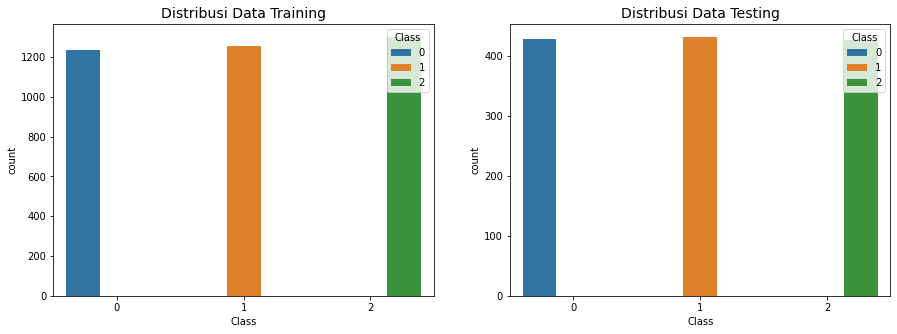

In [8]:
train = pd.DataFrame(train_set.samples,  columns=['Images', 'Class'])
test = pd.DataFrame(test_set.samples,  columns=['Images', 'Class'])

plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.countplot('Class', data=train, hue='Class');
plt.title('Distribusi Data Training', fontsize=14);

plt.subplot(122)
sns.countplot('Class', data=test, hue='Class');
plt.title('Distribusi Data Testing', fontsize=14);

In [9]:
label2cat = train_set.classes
label2cat

['Covid-19', 'Normal', 'Pneumonia']

In [10]:
#cek
loader = iter(trainloader)
images, labels = next(loader)
images.shape

torch.Size([128, 1, 224, 224])

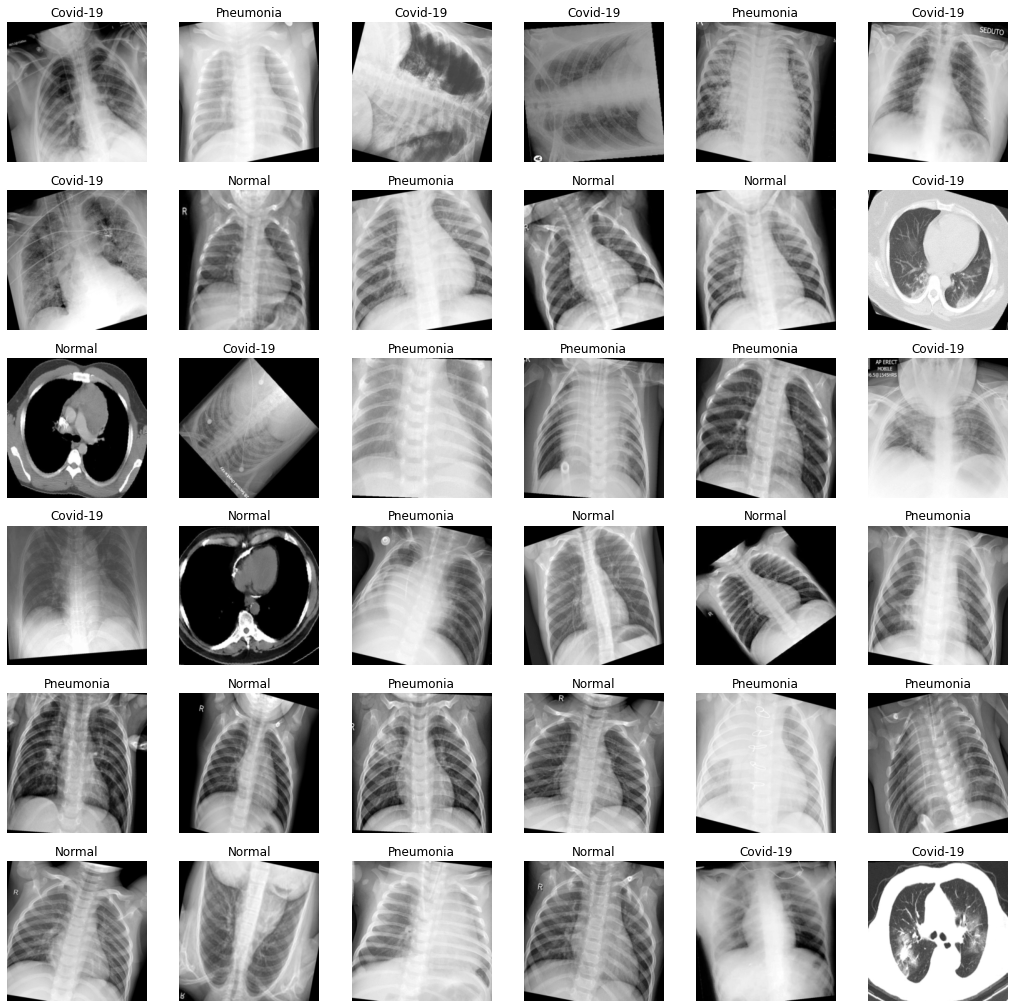

In [11]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img.view(224, 224).cpu(), cmap='gray')
    label = label2cat[label.item()]
    ax.set_title(f"{label}")
    ax.axis('off');

## Arsitektur and Config >> Tune Kernel(3,3)Padding(1,1)

In [12]:
# plt.figure(figsize=(50, 100))
# arsitektur = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/arsitektur/arsitektur_2.png')
# plt.imshow(arsitektur)
# plt.axis('off');

In [30]:
class CNN(nn.Module):
    def __init__(self, in_channel, conv1, conv2, conv3, conv4, kernel, pad, 
                 out_channel, in_size, n1, n2, dropout, out_size):
        super().__init__()
        
        self.convolutional = nn.Sequential(
            
            conv_block(in_channel, conv1, kernel=kernel, pad=pad),
            conv_block(conv1, conv2, kernel=kernel, pad=pad),
            conv_block(conv2, conv3, kernel=kernel, pad=pad),
            conv_block(conv3, conv4, kernel=kernel, pad=pad),
            conv_block(conv4, out_channel, kernel=kernel, pad=pad),
            nn.Flatten()
            
        )
        
        self.fc = nn.Sequential(
            
            linear_block(in_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, out_size, activation='lsoftmax')
        )
        
        
    def forward(self, x):
        x = self.convolutional(x)
        x = self.fc(x)
        return x
    
        

In [31]:
config = set_config ({
    
    "batch_size" : bs,
    "crop_size" : crop_size,
    "in_channel" : 1,
    "conv1" : 8,
    "conv2" : 16,
    "conv3" : 32,
    "conv4" : 64,
    "out_channel" : 256,
    "kernel" : 3,
    "pad" : 1,
    "in_size" : 256*7*7,
    "n1" : 512,
    "n2" : 256,
    "dropout" : 0.15,
    "out_size" : 3,
    "batch_norm" : "False",
    "author" : "Ridho Alhafizhi"
    
})

## Training Preparation >> MCOC >> lr : 0,001

In [32]:
model = CNN(config.in_channel, config.conv1, config.conv2, config.conv3, config.conv4, config.kernel, config.pad, config.out_channel, config.in_size, config.n1, config.n2, config.dropout, config.out_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/model-covid/model-covid-multiclass/model-tunning-2/",early_stop_patience=10, plot_every=5)

In [33]:
parameter = summary(model, (1,224,224))
# torch.save(parameter,"model/model-covid/model-covid-multiclass/model-tunning-2/model/total-params.pth")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]              80
              ReLU-2          [-1, 8, 224, 224]               0
         MaxPool2d-3          [-1, 8, 112, 112]               0
         ConvBlock-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,168
              ReLU-6         [-1, 16, 112, 112]               0
         MaxPool2d-7           [-1, 16, 56, 56]               0
         ConvBlock-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,640
             ReLU-10           [-1, 32, 56, 56]               0
        MaxPool2d-11           [-1, 32, 28, 28]               0
        ConvBlock-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
             ReLU-14           [-1, 64,

In [34]:
model

CNN(
  (convolutional): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (maxpool): MaxPool2

## Training



Epoch     1
Train_cost  = 1.0437 | Test_cost  = 0.8028 | Train_score = 0.4137 | Test_score = 0.6223 |




Epoch     2
Train_cost  = 0.7323 | Test_cost  = 0.5760 | Train_score = 0.6530 | Test_score = 0.7259 |




Epoch     3
Train_cost  = 0.5370 | Test_cost  = 0.4954 | Train_score = 0.7512 | Test_score = 0.7788 |




Epoch     4
Train_cost  = 0.4411 | Test_cost  = 0.3555 | Train_score = 0.8042 | Test_score = 0.8684 |




Epoch     5
Train_cost  = 0.3810 | Test_cost  = 0.3654 | Train_score = 0.8412 | Test_score = 0.8528 |


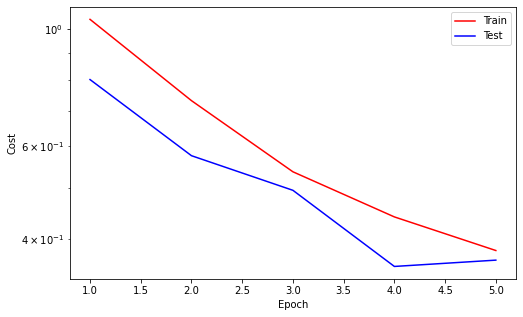

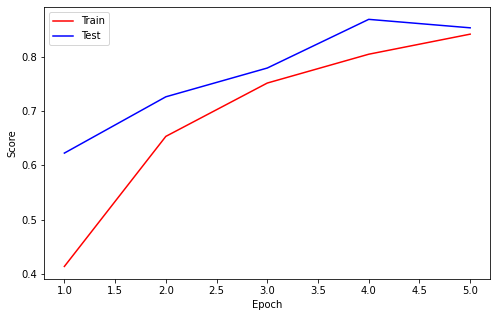

==> EarlyStop patience =  1 | Best test_score: 0.8684




Epoch     6
Train_cost  = 0.3335 | Test_cost  = 0.3441 | Train_score = 0.8609 | Test_score = 0.8442 |
==> EarlyStop patience =  2 | Best test_score: 0.8684




Epoch     7
Train_cost  = 0.3003 | Test_cost  = 0.2483 | Train_score = 0.8712 | Test_score = 0.8956 |




Epoch     8
Train_cost  = 0.2905 | Test_cost  = 0.2673 | Train_score = 0.8715 | Test_score = 0.8910 |
==> EarlyStop patience =  1 | Best test_score: 0.8956




Epoch     9
Train_cost  = 0.2553 | Test_cost  = 0.2616 | Train_score = 0.9003 | Test_score = 0.8824 |
==> EarlyStop patience =  2 | Best test_score: 0.8956




Epoch    10
Train_cost  = 0.2551 | Test_cost  = 0.2216 | Train_score = 0.8966 | Test_score = 0.9151 |


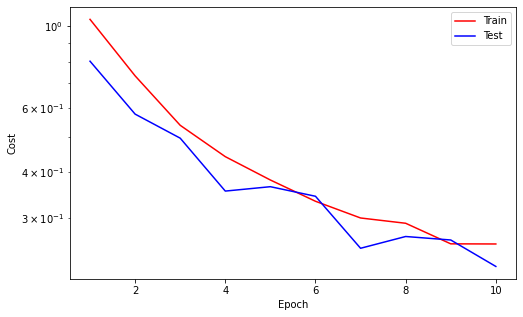

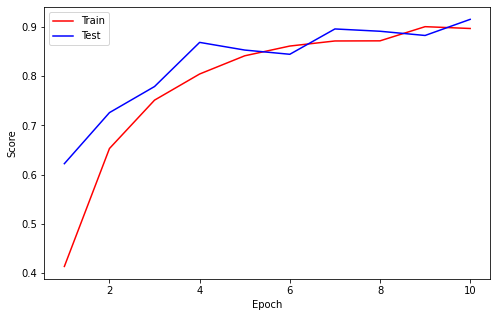



Epoch    11
Train_cost  = 0.2351 | Test_cost  = 0.2586 | Train_score = 0.8992 | Test_score = 0.8949 |
==> EarlyStop patience =  1 | Best test_score: 0.9151




Epoch    12
Train_cost  = 0.2194 | Test_cost  = 0.2316 | Train_score = 0.9066 | Test_score = 0.9050 |
==> EarlyStop patience =  2 | Best test_score: 0.9151




Epoch    13
Train_cost  = 0.2230 | Test_cost  = 0.2724 | Train_score = 0.9119 | Test_score = 0.8925 |
==> EarlyStop patience =  3 | Best test_score: 0.9151




Epoch    14
Train_cost  = 0.1883 | Test_cost  = 0.2285 | Train_score = 0.9243 | Test_score = 0.9104 |
==> EarlyStop patience =  4 | Best test_score: 0.9151




Epoch    15
Train_cost  = 0.1776 | Test_cost  = 0.2358 | Train_score = 0.9237 | Test_score = 0.9019 |


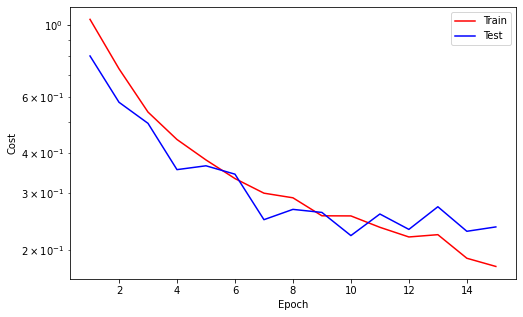

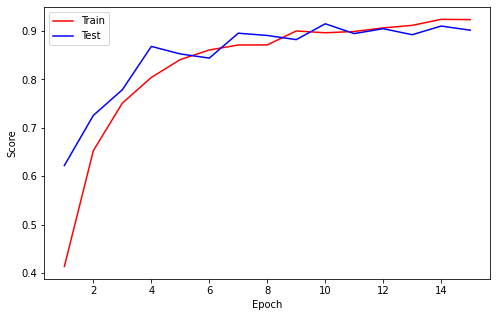

==> EarlyStop patience =  5 | Best test_score: 0.9151




Epoch    16
Train_cost  = 0.1880 | Test_cost  = 0.1962 | Train_score = 0.9187 | Test_score = 0.9182 |




Epoch    17
Train_cost  = 0.1725 | Test_cost  = 0.2303 | Train_score = 0.9332 | Test_score = 0.9073 |
==> EarlyStop patience =  1 | Best test_score: 0.9182




Epoch    18
Train_cost  = 0.1702 | Test_cost  = 0.2206 | Train_score = 0.9317 | Test_score = 0.9050 |
==> EarlyStop patience =  2 | Best test_score: 0.9182




Epoch    19
Train_cost  = 0.1666 | Test_cost  = 0.3034 | Train_score = 0.9296 | Test_score = 0.8894 |
==> EarlyStop patience =  3 | Best test_score: 0.9182




Epoch    20
Train_cost  = 0.1483 | Test_cost  = 0.2170 | Train_score = 0.9369 | Test_score = 0.9182 |


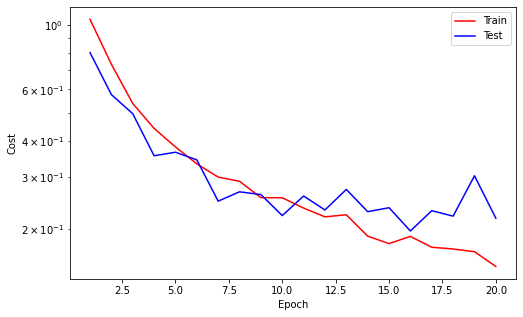

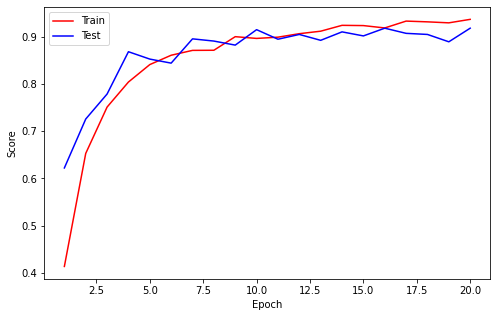

==> EarlyStop patience =  4 | Best test_score: 0.9182




Epoch    21
Train_cost  = 0.1407 | Test_cost  = 0.2719 | Train_score = 0.9422 | Test_score = 0.9112 |
==> EarlyStop patience =  5 | Best test_score: 0.9182




Epoch    22
Train_cost  = 0.1441 | Test_cost  = 0.2492 | Train_score = 0.9433 | Test_score = 0.9120 |
==> EarlyStop patience =  6 | Best test_score: 0.9182




Epoch    23
Train_cost  = 0.1311 | Test_cost  = 0.2388 | Train_score = 0.9467 | Test_score = 0.9167 |
==> EarlyStop patience =  7 | Best test_score: 0.9182




Epoch    24
Train_cost  = 0.1221 | Test_cost  = 0.1820 | Train_score = 0.9488 | Test_score = 0.9315 |




Epoch    25
Train_cost  = 0.1216 | Test_cost  = 0.2560 | Train_score = 0.9528 | Test_score = 0.9174 |


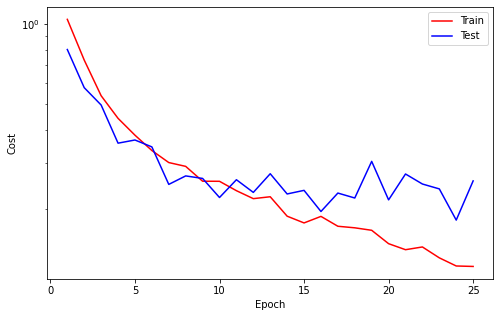

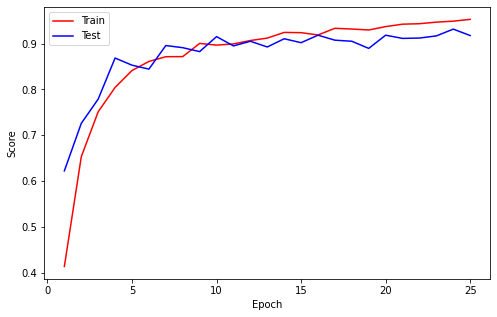

==> EarlyStop patience =  1 | Best test_score: 0.9315




Epoch    26
Train_cost  = 0.1183 | Test_cost  = 0.1943 | Train_score = 0.9533 | Test_score = 0.9237 |
==> EarlyStop patience =  2 | Best test_score: 0.9315




Epoch    27
Train_cost  = 0.1050 | Test_cost  = 0.2190 | Train_score = 0.9620 | Test_score = 0.9136 |
==> EarlyStop patience =  3 | Best test_score: 0.9315




Epoch    28
Train_cost  = 0.1091 | Test_cost  = 0.2059 | Train_score = 0.9557 | Test_score = 0.9369 |




Epoch    29
Train_cost  = 0.1070 | Test_cost  = 0.2673 | Train_score = 0.9599 | Test_score = 0.9182 |
==> EarlyStop patience =  1 | Best test_score: 0.9369




Epoch    30
Train_cost  = 0.1253 | Test_cost  = 0.2261 | Train_score = 0.9496 | Test_score = 0.9307 |


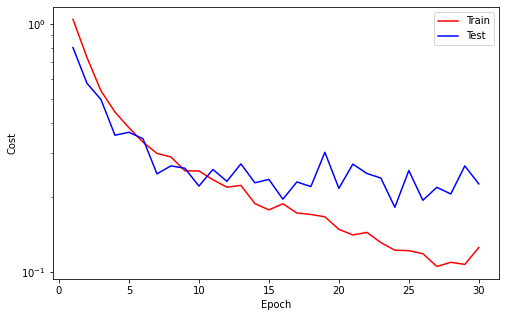

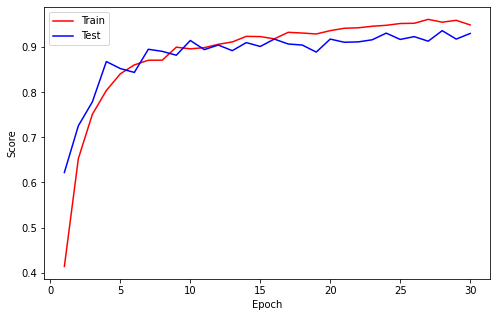

==> EarlyStop patience =  2 | Best test_score: 0.9369




Epoch    31
Train_cost  = 0.0873 | Test_cost  = 0.2082 | Train_score = 0.9662 | Test_score = 0.9369 |
==> EarlyStop patience =  3 | Best test_score: 0.9369




Epoch    32
Train_cost  = 0.1031 | Test_cost  = 0.1963 | Train_score = 0.9602 | Test_score = 0.9268 |
==> EarlyStop patience =  4 | Best test_score: 0.9369




Epoch    33
Train_cost  = 0.0948 | Test_cost  = 0.2105 | Train_score = 0.9623 | Test_score = 0.9283 |
==> EarlyStop patience =  5 | Best test_score: 0.9369




Epoch    34
Train_cost  = 0.0905 | Test_cost  = 0.2321 | Train_score = 0.9636 | Test_score = 0.9167 |
==> EarlyStop patience =  6 | Best test_score: 0.9369




Epoch    35
Train_cost  = 0.0813 | Test_cost  = 0.1841 | Train_score = 0.9665 | Test_score = 0.9463 |


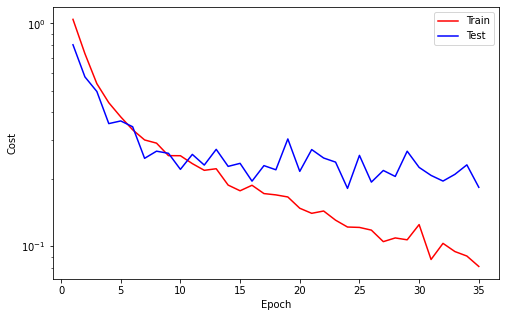

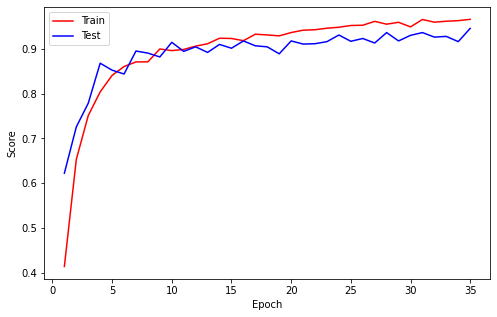



Epoch    36
Train_cost  = 0.0764 | Test_cost  = 0.2686 | Train_score = 0.9726 | Test_score = 0.9245 |
==> EarlyStop patience =  1 | Best test_score: 0.9463




Epoch    37
Train_cost  = 0.0799 | Test_cost  = 0.2709 | Train_score = 0.9683 | Test_score = 0.9112 |
==> EarlyStop patience =  2 | Best test_score: 0.9463




Epoch    38
Train_cost  = 0.0874 | Test_cost  = 0.2104 | Train_score = 0.9668 | Test_score = 0.9424 |
==> EarlyStop patience =  3 | Best test_score: 0.9463




Epoch    39
Train_cost  = 0.0634 | Test_cost  = 0.2708 | Train_score = 0.9763 | Test_score = 0.9237 |
==> EarlyStop patience =  4 | Best test_score: 0.9463




Epoch    40
Train_cost  = 0.0671 | Test_cost  = 0.1858 | Train_score = 0.9765 | Test_score = 0.9377 |


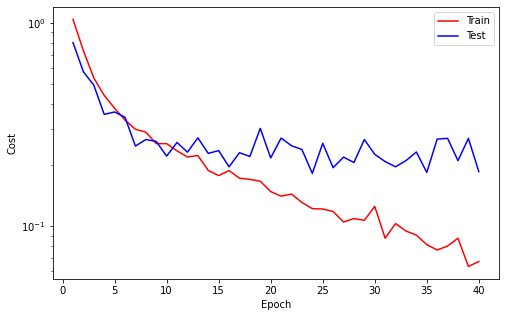

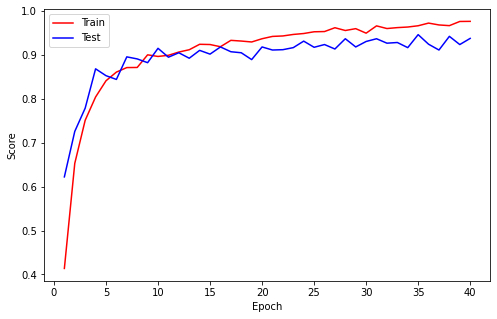

==> EarlyStop patience =  5 | Best test_score: 0.9463




Epoch    41
Train_cost  = 0.0757 | Test_cost  = 0.2524 | Train_score = 0.9734 | Test_score = 0.9268 |
==> EarlyStop patience =  6 | Best test_score: 0.9463




Epoch    42
Train_cost  = 0.0595 | Test_cost  = 0.2639 | Train_score = 0.9792 | Test_score = 0.9213 |
==> EarlyStop patience =  7 | Best test_score: 0.9463




Epoch    43
Train_cost  = 0.0759 | Test_cost  = 0.2989 | Train_score = 0.9718 | Test_score = 0.9206 |
==> EarlyStop patience =  8 | Best test_score: 0.9463




Epoch    44
Train_cost  = 0.0576 | Test_cost  = 0.2772 | Train_score = 0.9786 | Test_score = 0.9322 |
==> EarlyStop patience =  9 | Best test_score: 0.9463




Epoch    45
Train_cost  = 0.0597 | Test_cost  = 0.2734 | Train_score = 0.9781 | Test_score = 0.9260 |


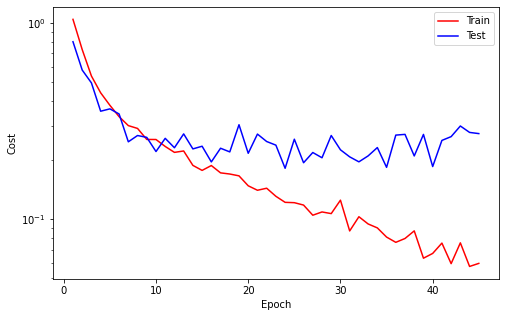

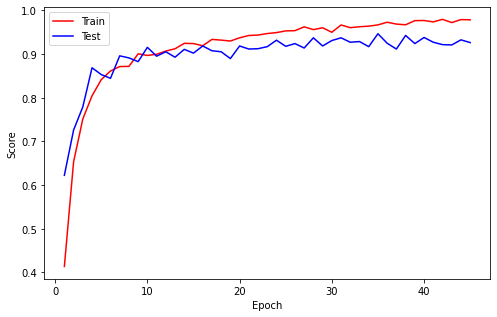

==> EarlyStop patience = 10 | Best test_score: 0.9463
==> Execute Early Stopping at epoch: 45 | Best test_score: 0.9463
==> Best model is saved at model/model-covid/model-covid-multiclass/model-tunning-2/


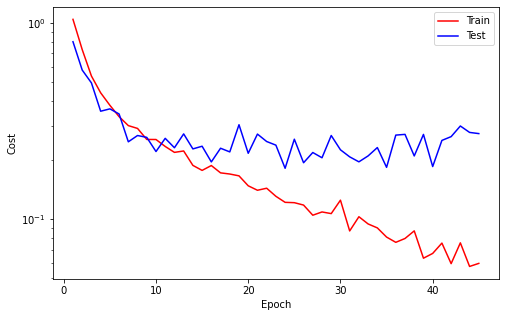

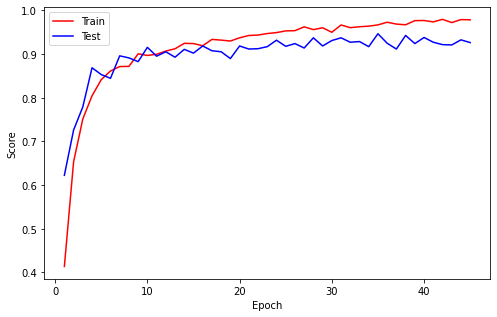

In [35]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Evaluation Model

### Accuracy and Cost

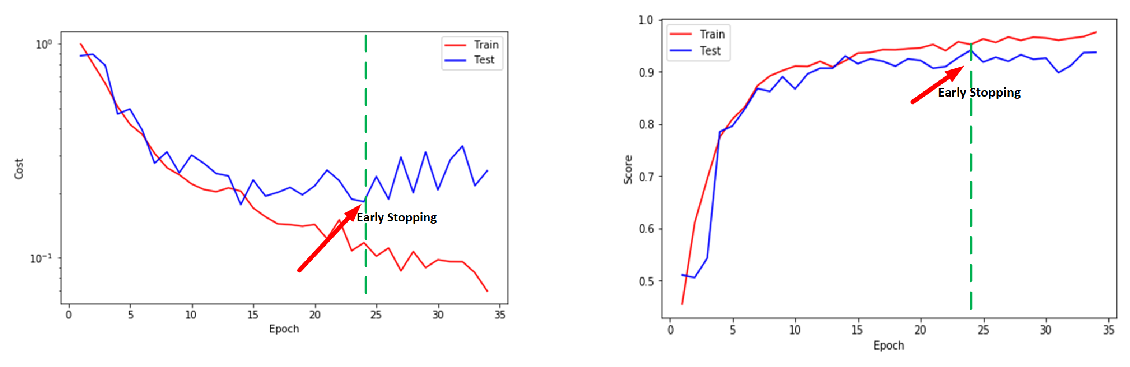

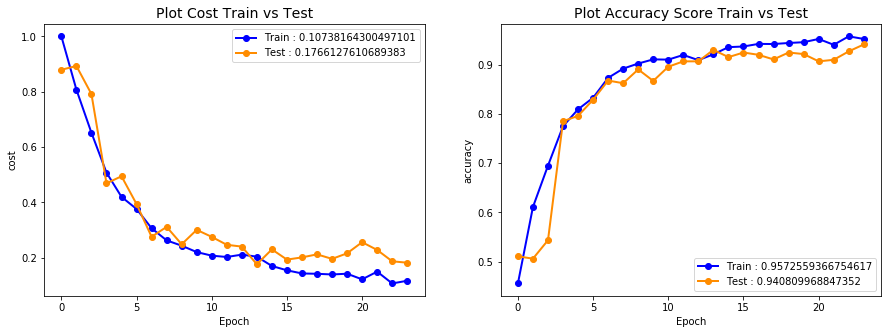

In [ ]:
# df = pd.DataFrame(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/logs.pth", map_location="cpu"))
# df;

# plt.figure(figsize=(20,10))
# plt.subplot(121)
# train_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/early_stop_cost.png')
# plt.imshow(train_cm)
# plt.axis('off');

# plt.subplot(122)
# test_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/early_stop_score.png')
# plt.imshow(test_cm) 
# plt.axis('off');


# plt.figure(figsize=(15,5))
# plt.subplot(121)
# plt.title("Plot Cost Train vs Test", fontsize=14)
# plt.plot(df.train_cost, 'bo-',linewidth=2, label=f"Train : {df.train_cost.min()}")
# plt.plot(df.test_cost, color='darkorange', marker='o', linewidth=2, label=f"Test : {df.test_cost.min()}")
# plt.xlabel("Epoch"); plt.ylabel("cost"); plt.legend();

# plt.subplot(122)
# plt.title("Plot Accuracy Score Train vs Test", fontsize=14)
# plt.plot(df.train_score, 'bo-',linewidth=2, label=f"Train : {df.train_score.max()}")
# plt.plot(df.test_score, color='darkorange',marker='o', linewidth=2, label=f"Test : {df.test_score.max()}")
# plt.xlabel("Epoch"); plt.ylabel("accuracy"); plt.legend();

### Confusion Matrix

              precision    recall  f1-score   support

    Covid-19       0.97      0.99      0.98      1235
      Normal       0.96      0.96      0.96      1255
   Pneumonia       0.99      0.97      0.98      1300

    accuracy                           0.97      3790
   macro avg       0.97      0.97      0.97      3790
weighted avg       0.97      0.97      0.97      3790

              precision    recall  f1-score   support

    Covid-19       0.97      0.93      0.95       427
      Normal       0.91      0.94      0.93       431
   Pneumonia       0.96      0.96      0.96       426

    accuracy                           0.95      1284
   macro avg       0.95      0.95      0.95      1284
weighted avg       0.95      0.95      0.95      1284



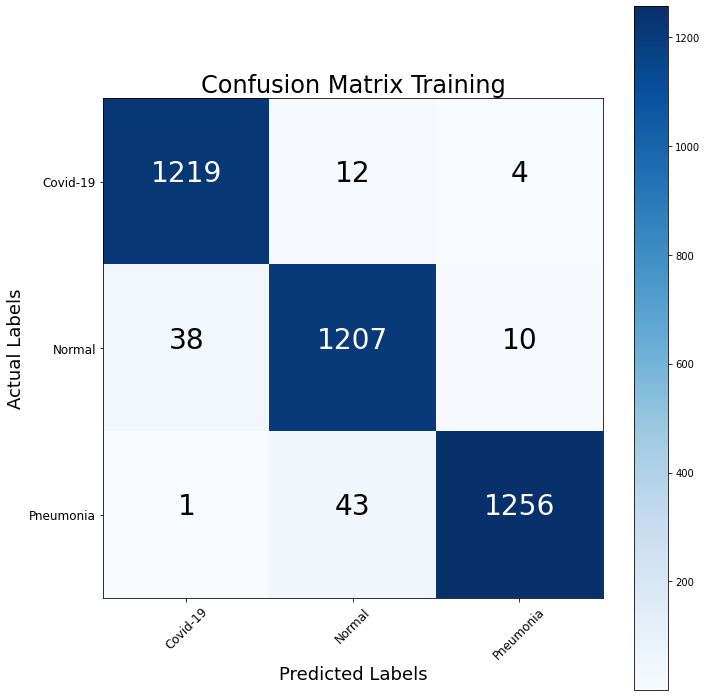

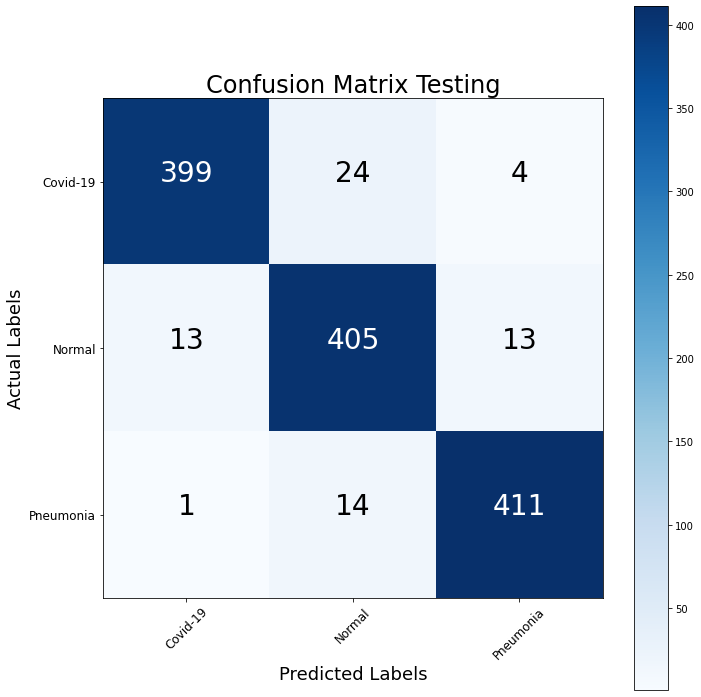

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('Actual Labels', fontsize=18)
    plt.xlabel('Predicted Labels',fontsize=18)
    
    
# Graphical analytics
def predictionsplot_train(model, device, trainloader):
        model.train(False)
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
actuals, predictions = predictionsplot_train(model, device, trainloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix Training', fontsize=24)
plot_confusion_matrix(cm, names)
plt.savefig("/content/model/model-covid/model-covid-multiclass/model-tunning-2/plot_cm_train.png")

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "/content/model/model-covid/model-covid-multiclass/model-tunning-2/report_train.pth" )
print(report)

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(actuals, predictions)
# # precision tp / (tp + fp)
# precision = precision_score(actuals, predictions)
# # recall: tp / (tp + fn)
# recall = recall_score(actuals, predictions)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(actuals, predictions)

# train_report = set_config ({
    
#     "accuracy" : accuracy,
#     "recall_score" : recall,
#     "precision_score" : precision,
#     "f1_score" : f1
# })

# torch.save(train_report,"model-CNN/model-covid/model-covid-multiclass/train_report.pth")

    
# Graphical analytics
def predictionsplot_test(model, device, testloader):
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(labels.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = predictionsplot_test(model, device, testloader)
cm = confusion_matrix(actuals, predictions)
names = (train_set.classes)

plt.figure(figsize=(10,10))
plt.title('Confusion Matrix Testing', fontsize=24)
plot_confusion_matrix(cm, names)
plt.savefig("/content/model/model-covid/model-covid-multiclass/model-tunning-2/plot_cm_test.png")

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(actuals, predictions)
# # precision tp / (tp + fp)
# precision = precision_score(actuals, predictions)
# # recall: tp / (tp + fn)
# recall = recall_score(actuals, predictions)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(actuals, predictions)

# test_report = set_config ({
    
#     "accuracy" : accuracy,
#     "recall_score" : recall,
#     "precision_score" : precision,
#     "f1_score" : f1
# })

# torch.save(test_report,"model-CNN/model-covid/model-covid-multiclass/test_report.pth")

target_names = train_set.classes
report = (classification_report(actuals, predictions, target_names=target_names))
torch.save(report, "/content/model/model-covid/model-covid-multiclass/model-tunning-2/report_test.pth" )
print(report)

 << Traning Report >> 

              precision    recall  f1-score   support

    Covid-19       0.96      0.98      0.97      1235
      Normal       0.95      0.95      0.95      1255
   Pneumonia       0.98      0.97      0.97      1300

    accuracy                           0.96      3790
   macro avg       0.96      0.96      0.96      3790
weighted avg       0.96      0.96      0.96      3790

 

 << Testing Report >> 

              precision    recall  f1-score   support

    Covid-19       0.93      0.94      0.94       427
      Normal       0.93      0.93      0.93       431
   Pneumonia       0.96      0.96      0.96       426

    accuracy                           0.94      1284
   macro avg       0.94      0.94      0.94      1284
weighted avg       0.94      0.94      0.94      1284



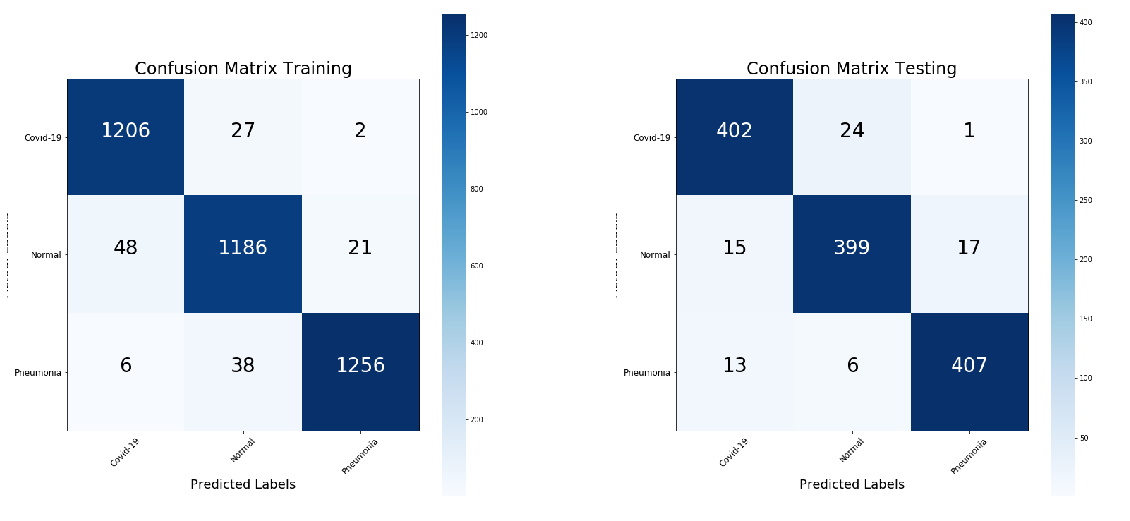

In [ ]:
print(" << Traning Report >> \n")
print(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/report_train.pth"))

print(" \n\n << Testing Report >> \n")
print(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/report_test.pth"))

plt.figure(figsize=(20,25))
plt.subplot(121)
train_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/plot_cm_train.png')
plt.imshow(train_cm)
plt.axis('off');

plt.subplot(122)
test_cm = plt.imread('model/model-covid/model-covid-multiclass/model-tunning-2/plot/plot_cm_test.png')
plt.imshow(test_cm) 
plt.axis('off');

### ROC Plot

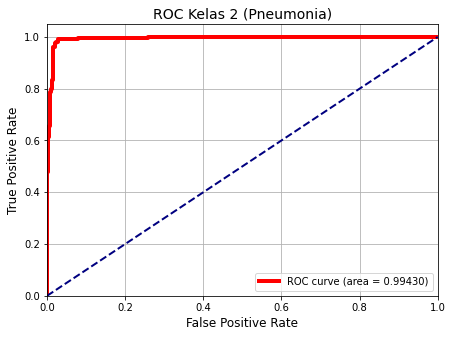

In [40]:
def test_class_probabilities(model, device, testloader, which_class):
    model.eval()
    actuals_test = []
    probabilities = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals_test.extend(labels.view_as(prediction) == which_class)
            probabilities.extend(output[:, which_class])
    return [i.item() for i in actuals_test], [i.item() for i in probabilities]

which_class = 2 #[0,1,2] >> kelas yang mana??
actuals_test, class_probabilities = test_class_probabilities(model, device, testloader, which_class)

fpr_test, tpr_test, _ = roc_curve(actuals_test, class_probabilities)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))

plt.plot(fpr_test, tpr_test, color='red',lw=4, label='ROC curve (area = %0.5f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Kelas 2 (Pneumonia)', fontsize=14)
plt.legend(loc="lower right")
plt.grid('on')

plt.savefig("/content/model/model-covid/model-covid-multiclass/model-tunning-2/roc_class_2.png")
plt.show()

## Load Model

In [ ]:
weights = torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/model/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)
model = model.to(device)

In [ ]:
torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/configs.pth")

Config(author=Ridho Alhafizhi, batch_norm=False, batch_size=128, conv1=8, conv2=16, conv3=32, conv4=64, crop_size=224, dropout=0.15, in_channel=1, in_size=12544, kernel=5, n1=512, n2=256, out_channel=256, out_size=3, pad=2)

In [ ]:
df = pd.DataFrame(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/logs.pth", map_location="cpu"))
df;

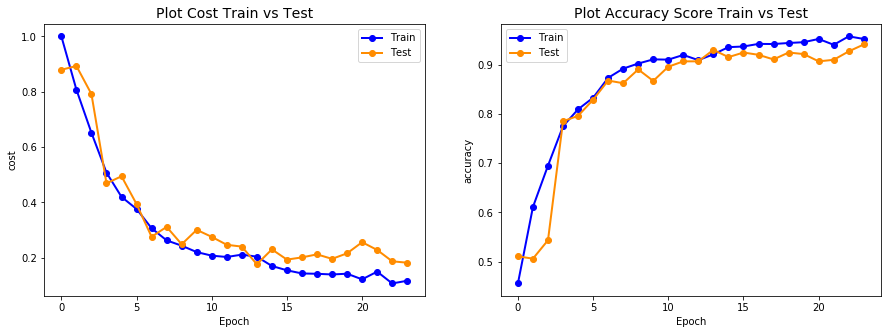

In [ ]:
df = pd.DataFrame(torch.load("model/model-covid/model-covid-multiclass/model-tunning-2/report/logs.pth", map_location="cpu"))
df;

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Plot Cost Train vs Test", fontsize=14)
plt.plot(df.train_cost, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_cost, color='darkorange', marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.title("Plot Accuracy Score Train vs Test", fontsize=14)
plt.plot(df.train_score, 'bo-',linewidth=2, label="Train")
plt.plot(df.test_score, color='darkorange',marker='o', linewidth=2, label="Test")
plt.xlabel("Epoch"); plt.ylabel("accuracy"); plt.legend();

# plt.savefig("model/model-covid/model-covid-multiclass/model-tunning-2/plot_score_cost_earlystop.png")

## Prediction

In [ ]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(images)
    preds = output.argmax(1)
preds

tensor([2, 0, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0,
        1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 1, 2, 0,
        0, 2, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0,
        1, 0, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 0, 0, 1,
        0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2,
        0, 1, 1, 1, 0, 0, 2, 2])

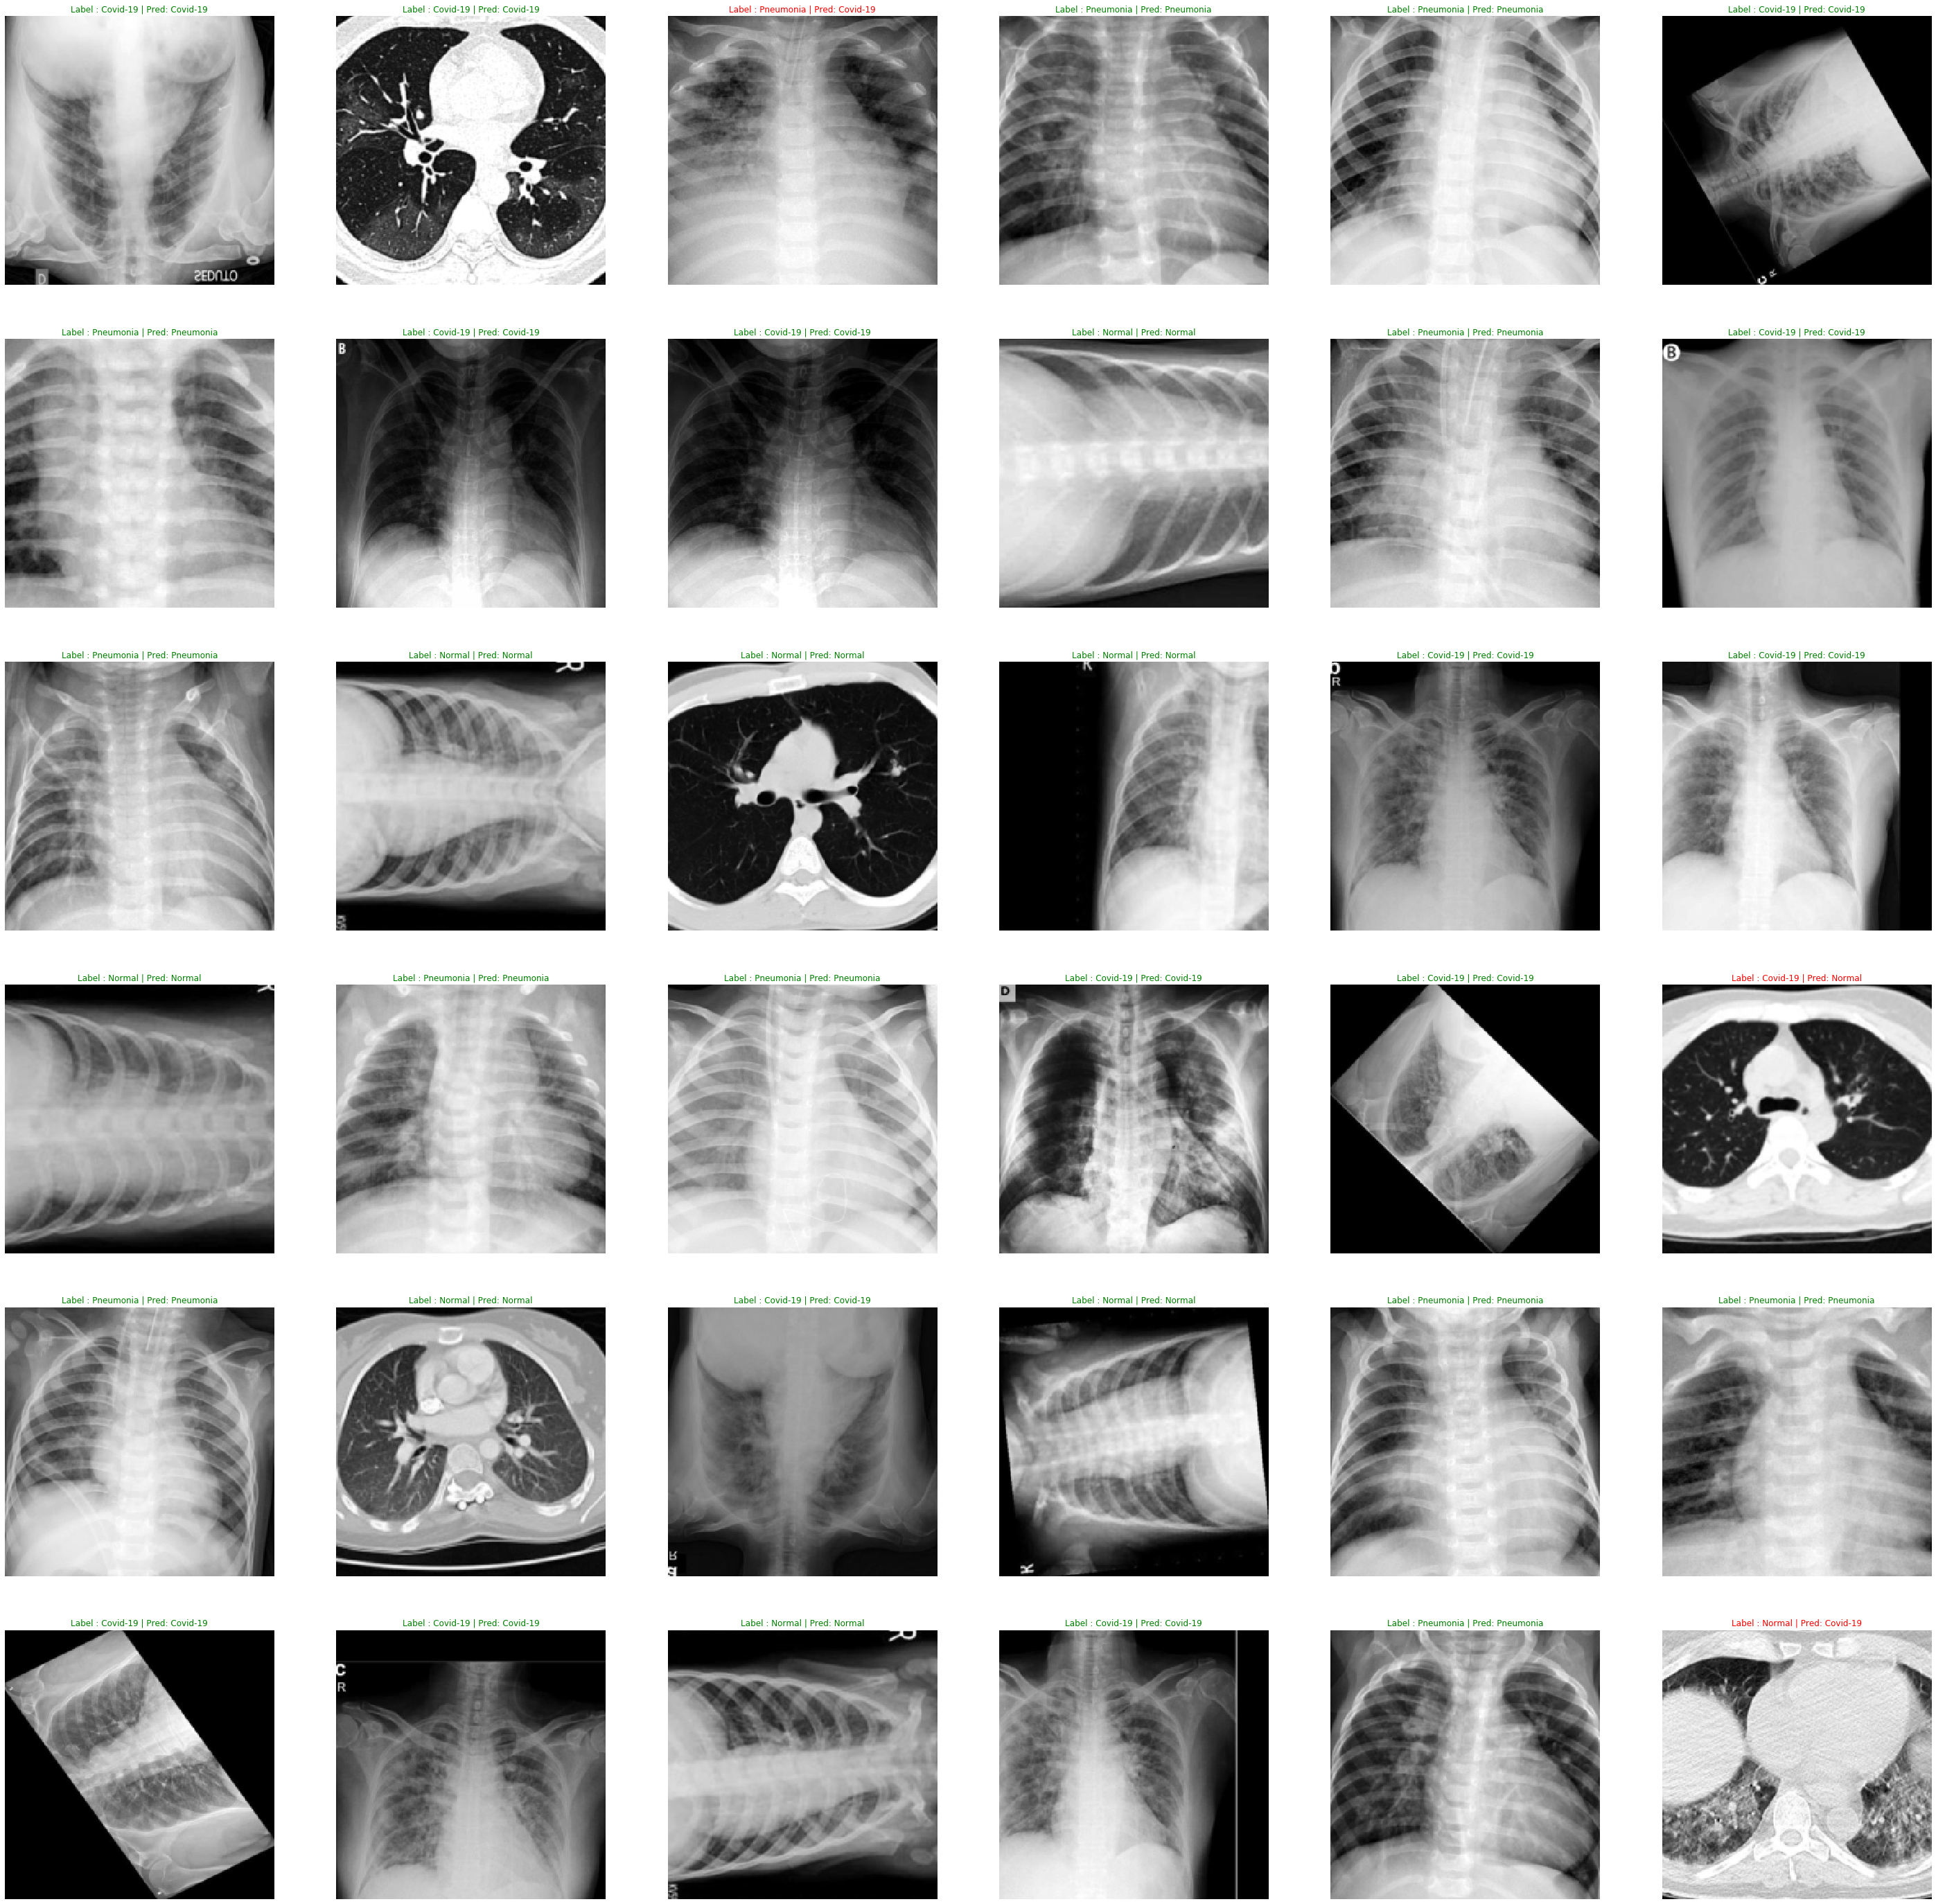

In [ ]:
fig, axes = plt.subplots(6,6, figsize=(50, 50))
for img, label, pred, ax in zip(images, labels, preds, axes.flatten()):
    font = {"color" : "g"} if label == pred else {"color":"r"}
    
    ax.imshow(img.view(224, 224).cpu(), cmap='gray')
    font = {"color" : "g"} if label == pred else {"color":"r"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label : {label} | Pred: {pred}", fontdict=font)
    ax.axis("off");
# plt.savefig("model-CNN/model-covid/model-covid-multiclass/model-tunning-2/prediction.png")

## Save in Zip

In [41]:
!zip -r model-tune-2.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/model-covid/ (stored 0%)
  adding: content/model/model-covid/model-covid-multiclass/ (stored 0%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/ (stored 0%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/.ipynb_checkpoints/ (stored 0%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/plot_cm_train.png (deflated 11%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/roc_class_2.png (deflated 6%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/weights_best.pth (deflated 7%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/report_test.pth (deflated 61%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/configs.pth (deflated 46%)
  adding: content/model/model-covid/model-covid-multiclass/model-tunning-2/roc_class_1.png (deflated 6%)
  adding: conte